In [8]:
import os
import os.path
import pyarrow as pa
import pyarrow.csv as csv
import pandas as pd
import bisect
from zipfile import *
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib_venn import venn3
import numpy as np
import re
import seaborn as sns
from time import process_time as pt
from Bio.Seq import Seq
from Bio import pairwise2
from matplotlib.colors import LogNorm, Normalize
from matplotlib.colors import LinearSegmentedColormap
import sys
import statistics
from tqdm import tqdm 
import swifter
import glob
from itertools import zip_longest
from collections import Counter
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cairosvg
import math
import scipy.stats as stats
import scipy as sp
import re

def unique(list1): #return only the unique elements of a list (no duplicates)
    x = np.array(list1)
    unique_list = np.unique(x).tolist()
    return unique_list

def calculate_fc(row):
    wk3_columns = [x for x in row.index if 'Week3' in x]
    fc_list = []
    for x in wk3_columns:
        y = x.replace('Week3','Week1')
        fc_list = fc_list + [row[x]/row[y]]
    return np.nanmean(fc_list),np.var(fc_list),np.var(fc_list)/np.nanmean(fc_list)

def rename_week_cols(df,append):
    old_names = [x for x in df.columns if 'Week' in x]
    new_names = ['_'.join(x.split('_')[1:]+[append]) for x in old_names]
    names_dict = dict(zip(old_names, new_names))
    
    return df.rename(columns=names_dict)

def expand_dataframe(row):
    cols = ['translated_where_possible','mutation_type','mutation_name','reclassed_mutation_type',
            'Week1_Allele_Freq','Week2_Allele_Freq','Week3_Allele_Freq','Week1_FC','Week2_FC','Week3_FC',
            'Week1_Log2FC','Week2_Log2FC','Week3_Log2FC','amp','Pool','exp']
    pools = ['A','B','C']
    df = pd.DataFrame(columns=cols)
    for pool in pools:
        data = [[row['translated_where_possible'],row['mutation_type'],row['mutation_name'],row['reclassed_mutation_type'],
                 row['Week1_Pool'+pool+'_AlleleFreq'],row['Week2_Pool'+pool+'_AlleleFreq'],row['Week3_Pool'+pool+'_AlleleFreq'],
                 row['Week1_Pool'+pool+'_FC'],row['Week2_Pool'+pool+'_FC'],row['Week3_Pool'+pool+'_FC'],
                 row['Week1_Pool'+pool+'_Log2FC'],row['Week2_Pool'+pool+'_Log2FC'],row['Week3_Pool'+pool+'_Log2FC'],row['amp'],pool,row['exp']]]
        dftemp = pd.DataFrame(data,columns = cols)
        df = pd.concat([df,dftemp])
    return df

def reclass_mutations(x):
    mut_dict = {
        'Alanine':'Alanine',
        'Frame Shift NHEJ':'Frame Shift',
        'In-frame NHEJ':'In Frame',
        'NHEJ Truncation':'Frame Shift',
        'None':'WT',
        'Precise Stop':'Frame Shift',
        'Silent':'Silent',
        'Single Deletion':'Deletion',
        'Substitution': 'Substitution',
        'Frame Shift': 'Frame Shift'
    }
    if x in mut_dict.keys():
        return(mut_dict[x])
    else:
        return x

def func1(t,a,b,c): #basic 1/x function with constants
    #return c + a * t ** b
    return a-b/(c+t)

def func2(t,a,b,c,d): #basic logrithmic function with constants
    return a-b/(c+t)
    #return a+b*np.log(t)

def calc_scores(row,sidf,fsdf,fopt,sopt):
    test = row[[x for x in row.keys().tolist() if 'Week3' in x and 'Log2' in x]].tolist()
    #find closest 180 data points to use in statistical comparison
    s_inds = np.argsort([np.abs(x-row['mean_wk1_allele_freq']) for x in sidf.Week1_Allele_Freq.tolist()])[:180]
    silents = sidf.iloc[s_inds]['Week3_Log2FC'].tolist()
    fs_inds = np.argsort([np.abs(x-row['mean_wk1_allele_freq']) for x in fsdf.Week1_Allele_Freq.tolist()])[:180]
    fs = fsdf.iloc[fs_inds]['Week3_Log2FC'].tolist()
    x,s_pval = stats.ranksums(test,silents,'less')
    y,fs_pval = stats.ranksums(test,fs,'greater')

    persist = 0
    deplete = 0

    for rep in [x for x in row.keys().tolist() if 'Week3' in x and 'Log2' in x]:
        af = rep.replace('Log2FC','AlleleFreq').replace('Week3','Week1')
        if row[rep] > func2(row[af],*fopt):
            persist = persist +1
        if row[rep] < func1(row[af],*sopt):
            deplete = deplete +1
    return s_pval,fs_pval,persist,deplete

def split_char_digits(s):
    return re.split('(\d+)',s)

def get_first_position(name):
    if name == 'WT':
        return -1
    else:
        return int(split_char_digits(name)[1])


In [9]:
def log2_fc(x):
    return np.log2(x+0.001)

def create_combined_file(t,path,exp):
    amp_ref = pd.read_excel('/'.join(path.split('/')[:-1]+['Input','POT1_Amplicon_Sequences.xlsx']))
    cdf = pd.DataFrame()
    all_amps = os.listdir(os.path.join(path,t))
    for amp in all_amps:
        exon = amp_ref[amp_ref['Amplicon #']==amp]['Exon #'].item()
        if os.path.isfile(os.path.join(path,t,amp,'5_Relative_to_file_read_count.csv')) and os.path.isfile(os.path.join(path,t,amp,'7_protein_chracterized_unbiased.csv')):
            reads_df = pd.read_csv(os.path.join(path,t,amp,'5_Relative_to_file_read_count.csv'))
            reads_df = reads_df.dropna()
            reads_df['mean_wk1_allele_freq'] = reads_df[[x for x in reads_df.columns if 'Week1' in x]].mean(axis=1)
            reads_df['mean_wk1_var'] = reads_df[[x for x in reads_df.columns if 'Week1' in x]].var(axis=1)
            reads_df['wk1_dispersion'] = reads_df.apply(lambda x: x.mean_wk1_var/x.mean_wk1_allele_freq, axis=1)
            temp = reads_df.apply(lambda x: calculate_fc(x),axis=1)
            reads_df['mean_wk3_fc'] = [x[0] for x in temp]
            reads_df['mean_wk3_fc_var'] = [x[1] for x in temp]
            reads_df['mean_wk3_fc_dispersion'] = [x[2] for x in temp]
            reads_df['amp'] = amp
            reads_df['exp'] = exp
            reads_df['exon'] = exon
            reads_df['position'] = reads_df.mutation_name.apply(lambda x: get_first_position(x))

            reads_df = rename_week_cols(reads_df,'AlleleFreq').copy()

            fc_df = pd.read_csv(os.path.join(path,t,amp,'7_protein_chracterized_unbiased.csv'))
            fc_df = fc_df.dropna()
            fc_df = rename_week_cols(fc_df,'FC')
            fc_df = fc_df.drop(columns=['Aligned_translated','aligned_translated_adjusted_length','length','dash_number','pos','lastaa','row_number_in_graph','bp'])

            tdf = pd.concat([reads_df.set_index(['translated_where_possible','mutation_type','mutation_name']),fc_df.set_index(['translated_where_possible','mutation_type','mutation_name'])],axis=1)
            tdf = tdf.reset_index()
            cdf = pd.concat([cdf,tdf])
    return cdf

In [10]:
def find_underpowered_alleles(t,path,exp,expanded_df):
    pools = ['PoolA','PoolB','PoolC']

    amp_ref = pd.read_excel('/'.join(path.split('/')[:-1]+['Input','POT1_Amplicon_Sequences.xlsx']))
    udf = pd.DataFrame()
    all_amps = os.listdir(os.path.join(path,t))
    for amp in all_amps:
        exon = amp_ref[amp_ref['Amplicon #']==amp]['Exon #'].item()
        techrep_df = pd.read_csv(os.path.join(path,t,amp,'2_combined_collapsed.csv'))
        techrep_df = techrep_df.dropna()
        techrep_df = techrep_df.set_index(['translated_where_possible','mutation_type','mutation_name'])

        unfiltered_df = pd.read_csv(os.path.join(path,t,amp,'3_combined_collapsed_after_threshold.csv'))
        unfiltered_df = unfiltered_df.dropna()
        unfiltered_df = unfiltered_df.set_index(['translated_where_possible','mutation_type','mutation_name'])

        unfiltered_df = unfiltered_df[~unfiltered_df.index.isin(expanded_df.index)]
        unfiltered_df['amp'] = amp
        unfiltered_df = rename_week_cols(unfiltered_df,'').copy()
        unfiltered_df = unfiltered_df.drop(columns='__index_level_0__')
        unfiltered_df['num_bioreps'] = 0

        for index, row in unfiltered_df.iterrows():
            for pool in pools:
                rel_cols = [x for x in techrep_df.columns if 'Week1' in x and pool in x]
                num_trs = sum([techrep_df.loc[index,rel_cols[0]]>=5 for i in range(len(rel_cols))])
                if num_trs<=2:
                    unfiltered_df.loc[index,'Week1_%s_'%pool] = np.nan
                    unfiltered_df.loc[index,'Week2_%s_'%pool] = np.nan
                    unfiltered_df.loc[index,'Week3_%s_'%pool] = np.nan
            unfiltered_df.loc[index,'num_bioreps'] = int(sum(~np.isnan([unfiltered_df.loc[index,'Week1_%s_'%pools[i]] for i in range(len(pools))])))

        #normalize to read depth
        reads_info_df = pd.read_csv(os.path.join(path,t,amp,'df_reads_info.csv'))
        reads_info_df['file'] = reads_info_df.file.apply(lambda x: '_'.join(x.split('_')[1:-1]))
        reads_info_df = reads_info_df.groupby(by=['file']).mean().copy()
        unfiltered_df = unfiltered_df[unfiltered_df['num_bioreps']>0].copy()
        for column in [x[:-1] for x in unfiltered_df.columns if 'Week' in x]:
            unfiltered_df[column+"_AlleleFreq"] = unfiltered_df[column+'_'].apply(lambda x: x/reads_info_df.loc[column,'after collapse and threshold enforcement'])
            unfiltered_df=unfiltered_df.drop(columns=column+'_')
        unfiltered_df['mean_wk1_allele_freq'] = unfiltered_df[[x for x in unfiltered_df.columns if 'Week1' in x]].mean(axis=1)
        unfiltered_df['mean_wk1_var'] = unfiltered_df[[x for x in unfiltered_df.columns if 'Week1' in x]].var(axis=1)
        unfiltered_df['wk1_dispersion'] = unfiltered_df.apply(lambda x: x.mean_wk1_var/x.mean_wk1_allele_freq, axis=1)
        temp = unfiltered_df.apply(lambda x: calculate_fc(x),axis=1)
        unfiltered_df['mean_wk3_fc'] = [x[0] for x in temp]
        unfiltered_df['mean_wk3_fc_var'] = [x[1] for x in temp]
        unfiltered_df['mean_wk3_fc_dispersion'] = [x[2] for x in temp]

        #calculate fold change and log2 fold change
        for column in [x for x in unfiltered_df.columns if 'Week' in x]:
            week1col = '_'.join(['Week1'] + column.split('_')[1:])
            unfiltered_df[column.replace('AlleleFreq','FC')] = unfiltered_df.apply(lambda x: x[column]/x[week1col],axis=1)
            unfiltered_df[column.replace('AlleleFreq','Log2FC')] = unfiltered_df[column.replace('AlleleFreq','FC')].apply(lambda x: log2_fc(x))

        unfiltered_df['exp'] = exp

        udf = pd.concat([udf,unfiltered_df])        
    return udf

In [11]:
output_screen = '/data/annika/POT1_Screen_VUS_Combined/Screen/Output'
output_vus = '/data/annika/POT1_Screen_VUS_Combined/VUS/Output'
figure_output = '/data/annika/POT1_Screen_VUS_Combined/FigureGeneration/PersistenceDepletion'
thresh = '1e-06'

In [12]:
combined_screen = create_combined_file(thresh,output_screen,'screen')
combined_vus = create_combined_file(thresh,output_vus,'vus')
combined_3bioreps = pd.concat([combined_screen,combined_vus])

/tmp/ipykernel_9435/676702708.py:44: RuntimeWarning: invalid value encountered in double_scalars
  return np.nanmean(fc_list),np.var(fc_list),np.var(fc_list)/np.nanmean(fc_list)
/tmp/ipykernel_9435/676702708.py:44: RuntimeWarning: invalid value encountered in double_scalars
  return np.nanmean(fc_list),np.var(fc_list),np.var(fc_list)/np.nanmean(fc_list)
/tmp/ipykernel_9435/676702708.py:44: RuntimeWarning: invalid value encountered in double_scalars
  return np.nanmean(fc_list),np.var(fc_list),np.var(fc_list)/np.nanmean(fc_list)
/tmp/ipykernel_9435/676702708.py:44: RuntimeWarning: invalid value encountered in double_scalars
  return np.nanmean(fc_list),np.var(fc_list),np.var(fc_list)/np.nanmean(fc_list)
/tmp/ipykernel_9435/676702708.py:44: RuntimeWarning: invalid value encountered in double_scalars
  return np.nanmean(fc_list),np.var(fc_list),np.var(fc_list)/np.nanmean(fc_list)
/tmp/ipykernel_9435/676702708.py:44: RuntimeWarning: invalid value encountered in double_scalars
  return np.n

In [13]:
combined_3bioreps=combined_3bioreps[combined_3bioreps.mutation_type != 'Intronic NHEJ'].copy().reset_index(drop=True)
combined_3bioreps['reclassed_mutation_type'] = combined_3bioreps.mutation_type.apply(lambda x: reclass_mutations(x)) 

fc_list = [x for x in combined_3bioreps.columns if 'FC' in x]
for fc_col in fc_list:
    new_col = fc_col.replace('FC','Log2FC')
    combined_3bioreps[new_col] = combined_3bioreps[fc_col].apply(lambda x: log2_fc(x))

boundaries_df = pd.concat([combined_3bioreps[combined_3bioreps.reclassed_mutation_type=='Silent'],combined_3bioreps[combined_3bioreps.reclassed_mutation_type=='Frame Shift']])
bounddf_expanded = pd.DataFrame()
for index,row in boundaries_df.iterrows():
    tdf = expand_dataframe(row)
    bounddf_expanded = pd.concat([bounddf_expanded,tdf])

sidf = bounddf_expanded[bounddf_expanded.reclassed_mutation_type=='Silent'].copy()
fsdf = bounddf_expanded[bounddf_expanded.reclassed_mutation_type=='Frame Shift'].copy()
print("Number of silent mutation observations: %d" % len(sidf))
print("Silent mutations from first screen: %d" % len(sidf[sidf['exp']=='screen']))
print("Silent mutations from vus screen: %d" % len(sidf[sidf['exp']=='vus']))
print("Number of frame shift mutation obervations: %d" % len(fsdf))
print("Frame shift mutations from first screen: %d" % len(fsdf[fsdf['exp']=='screen']))
print("Frame shift mutations from vus screen: %d" % len(fsdf[fsdf['exp']=='vus']))

combined_3bioreps['mean_wk3_log2fc'] = combined_3bioreps.apply(lambda x: np.nanmean([x[y] for y in [x for x in combined_3bioreps.columns if 'Week3' in x and 'Log2' in x]]),axis=1)

Number of silent mutation observations: 2913
Silent mutations from first screen: 1833
Silent mutations from vus screen: 1080
Number of frame shift mutation obervations: 1662
Frame shift mutations from first screen: 858
Frame shift mutations from vus screen: 804


In [14]:
#sliding window binning to find 95th percentile

window = 200
slide = 1

tdf = sidf[['Week1_Allele_Freq','Week3_Log2FC']].copy()
tdf = tdf.sort_values(by='Week1_Allele_Freq').reset_index(drop=True)
s_mean_af = [tdf.iloc[x:x+window]['Week1_Allele_Freq'].mean() for x in range(0,len(tdf)-window,slide)]
s_pctile = [tdf.iloc[x:x+window]['Week3_Log2FC'].quantile(0.05,'midpoint') for x in range(0,len(tdf)-window,slide)]
sopt, scov = sp.optimize.curve_fit(func1, s_mean_af, s_pctile)

tdf2 = fsdf[['Week1_Allele_Freq','Week3_Log2FC']].copy()
tdf2 = tdf2.sort_values(by='Week1_Allele_Freq').reset_index(drop=True)
fs_mean_af = [tdf2.iloc[x:x+window]['Week1_Allele_Freq'].mean() for x in range(0,len(tdf2)-window,slide)]
fs_pctile = [tdf2.iloc[x:x+window]['Week3_Log2FC'].quantile(0.95,'midpoint') for x in range(0,len(tdf2)-window,slide)]
fopt, fcov = sp.optimize.curve_fit(func2, fs_mean_af, fs_pctile)



/home/annika/anaconda2/envs/LoHapAnalysisEnv/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


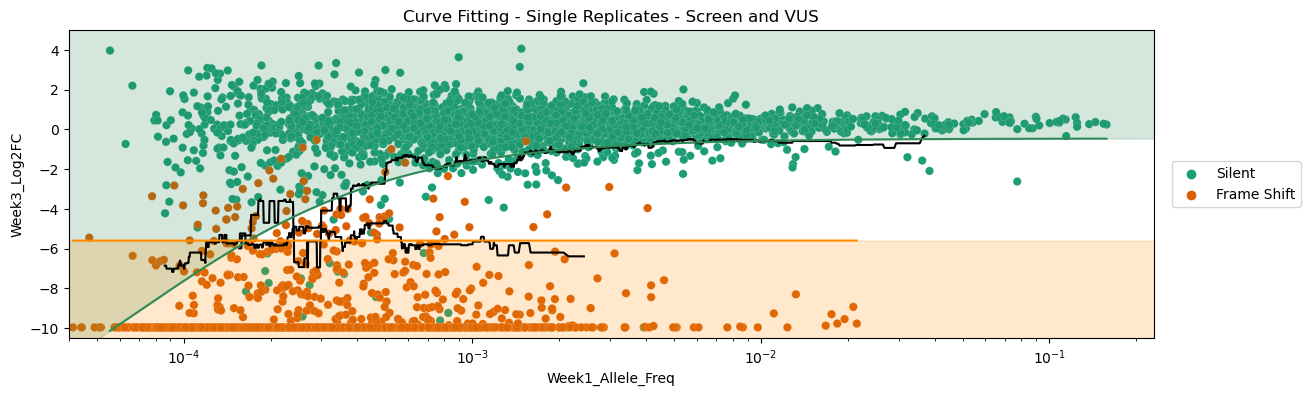

In [17]:
fig,ax = plt.subplots(figsize = (14,4))
ax = sns.scatterplot(data=bounddf_expanded,x='Week1_Allele_Freq',y='Week3_Log2FC',hue='reclassed_mutation_type',palette='Dark2', linewidth=0.1)
ax.plot(s_mean_af,s_pctile,'black')
ax.plot(tdf.Week1_Allele_Freq,func1(tdf.Week1_Allele_Freq, *sopt),'seagreen')
fill_xvals = [4e-5]+tdf.Week1_Allele_Freq.tolist()+[1]
ax.fill_between(x=fill_xvals,y1=func1(fill_xvals, *sopt),y2=5,color='seagreen',alpha=0.2)
ax.plot(fs_mean_af,fs_pctile,'black')
ax.plot(tdf2.Week1_Allele_Freq,func2(tdf2.Week1_Allele_Freq, *fopt),'darkorange')
ax.fill_between(x=fill_xvals,y1=np.mean(fs_pctile),y2=-10.5,color='darkorange',alpha=0.2)
ax.legend(bbox_to_anchor=(1.01, 0.5),loc='center left')
ax.set_xlim(4e-5,0.23)
ax.set_ylim(-10.5,5)
plt.xscale('log')
ax.set_title("Curve Fitting - Single Replicates - Screen and VUS")
fig.savefig(os.path.join(figure_output,'0a_Silent_FS_Curve_Fitting.png'),bbox_inches='tight')
fig.savefig(os.path.join(figure_output,'0a_Silent_FS_Curve_Fitting_Transparent.png'),bbox_inches='tight',transparent=True)
svg_path = os.path.join(figure_output,'0a_Silent_FS_Curve_Fitting.svg')
ai_path = os.path.join(figure_output,'0a_Silent_FS_Curve_Fitting.ai')
plt.rcParams['svg.fonttype'] = 'none'
# Save the heatmap as an SVG file
fig.savefig(svg_path, format="svg")
# Convert the SVG file to AI format
cairosvg.svg2pdf(url=svg_path, write_to=ai_path)
plt.show()
plt.close()

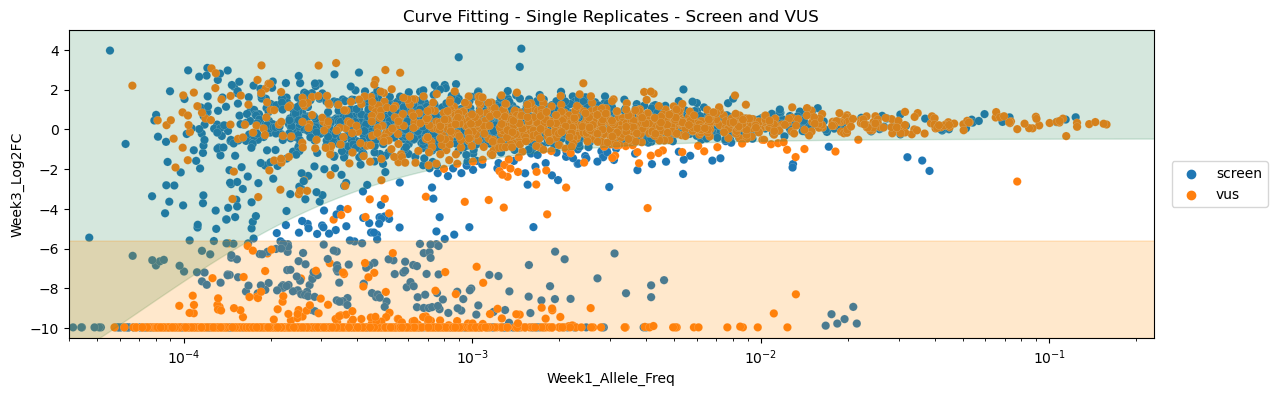

In [18]:
fig1,ax1 = plt.subplots(figsize = (14,4))
ax = sns.scatterplot(data=bounddf_expanded,x='Week1_Allele_Freq',y='Week3_Log2FC',hue='exp', linewidth=0.1)
fill_xvals = [4e-5]+tdf.Week1_Allele_Freq.tolist()+[1]
ax1.fill_between(x=fill_xvals,y1=func1(fill_xvals, *sopt),y2=5,color='seagreen',alpha=0.2)
ax1.fill_between(x=fill_xvals,y1=func2(fill_xvals, *fopt),y2=-10.5,color='darkorange',alpha=0.2)
ax1.legend(bbox_to_anchor=(1.01, 0.5),loc='center left')
ax1.set_xlim(4e-5,0.23)
ax1.set_ylim(-10.5,5)
plt.xscale('log')
ax1.set_title("Curve Fitting - Single Replicates - Screen and VUS")
fig1.savefig(os.path.join(figure_output,'0b_Silent_FS_ExpSplit.png'),bbox_inches='tight')
fig1.savefig(os.path.join(figure_output,'0b_Silent_FS_ExpSplit_Transparent.png'),bbox_inches='tight',transparent=True)
svg_path = os.path.join(figure_output,'0b_Silent_FS_ExpSplit.svg')
ai_path = os.path.join(figure_output,'0b_Silent_FS_ExpSplit.ai')
plt.rcParams['svg.fonttype'] = 'none'
# Save the heatmap as an SVG file
fig1.savefig(svg_path, format="svg")
# Convert the SVG file to AI format
cairosvg.svg2pdf(url=svg_path, write_to=ai_path)
plt.show()
plt.close()

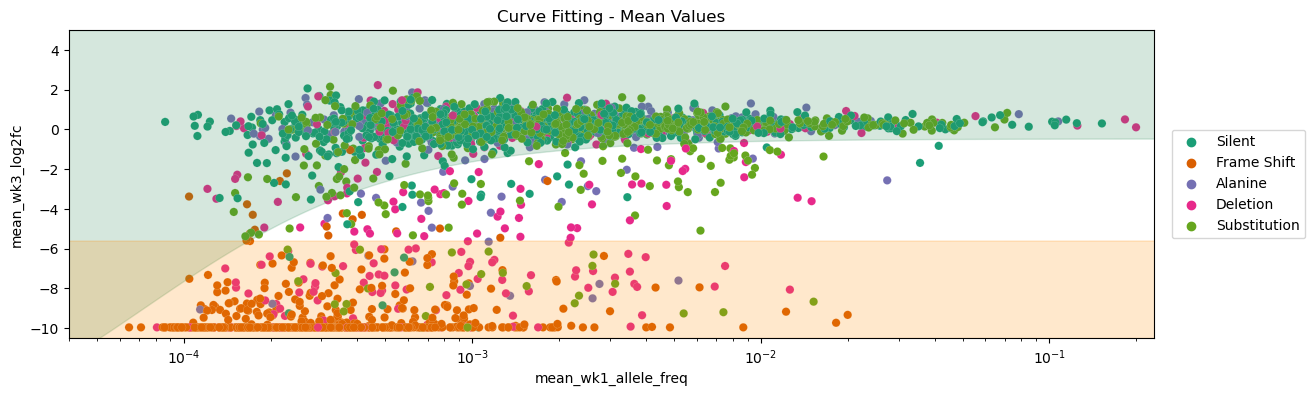

In [19]:
fig2,ax2 = plt.subplots(figsize = (14,4))
target_muts = ['Silent','Frame Shift','Alanine','Deletion','Substitution']
inds = combined_3bioreps.reclassed_mutation_type.apply(lambda x: x in target_muts).tolist()
target_df = combined_3bioreps[inds].copy()
ax2 = sns.scatterplot(data=target_df,x='mean_wk1_allele_freq',y='mean_wk3_log2fc',hue='reclassed_mutation_type',
                    hue_order=['Silent','Frame Shift','Alanine','Deletion','Substitution'], linewidth=0.1,
                    palette='Dark2')
ax2.fill_between(x=fill_xvals,y1=func1(fill_xvals, *sopt),y2=5,color='seagreen',alpha=0.2)
ax2.fill_between(x=fill_xvals,y1=func2(fill_xvals, *fopt),y2=-10.5,color='darkorange',alpha=0.2)
ax2.legend(bbox_to_anchor=(1.01, 0.5),loc='center left')
ax2.set_xlim(4e-5,0.23)
ax2.set_ylim(-10.5,5)
plt.xscale('log')
ax2.set_title("Curve Fitting - Mean Values")
fig2.savefig(os.path.join(figure_output,'0c_Mut_Mean_Curve.png'),bbox_inches='tight')
fig2.savefig(os.path.join(figure_output,'0c_Mut_Mean_Curve_Transparent.png'),bbox_inches='tight',transparent=True)
svg_path = os.path.join(figure_output,'0c_Mut_Mean_Curve.svg')
ai_path = os.path.join(figure_output,'0c_Mut_Mean_Curve.ai')
plt.rcParams['svg.fonttype'] = 'none'
# Save the heatmap as an SVG file
fig2.savefig(svg_path, format="svg")
# Convert the SVG file to AI format
cairosvg.svg2pdf(url=svg_path, write_to=ai_path)
plt.show()
plt.close()

In [43]:
combined_3bioreps.columns

Index(['translated_where_possible', 'mutation_type', 'mutation_name',
       'Week1_PoolA_AlleleFreq', 'Week1_PoolB_AlleleFreq',
       'Week1_PoolC_AlleleFreq', 'Week2_PoolA_AlleleFreq',
       'Week2_PoolB_AlleleFreq', 'Week2_PoolC_AlleleFreq',
       'Week3_PoolA_AlleleFreq', 'Week3_PoolB_AlleleFreq',
       'Week3_PoolC_AlleleFreq', 'mean_wk1_allele_freq', 'mean_wk1_var',
       'wk1_dispersion', 'mean_wk3_fc', 'mean_wk3_fc_var',
       'mean_wk3_fc_dispersion', 'amp', 'exp', 'exon', 'position',
       'Week1_PoolA_FC', 'Week1_PoolB_FC', 'Week1_PoolC_FC', 'Week2_PoolA_FC',
       'Week2_PoolB_FC', 'Week2_PoolC_FC', 'Week3_PoolA_FC', 'Week3_PoolB_FC',
       'Week3_PoolC_FC', 'reclassed_mutation_type', 'Week1_PoolA_Log2FC',
       'Week1_PoolB_Log2FC', 'Week1_PoolC_Log2FC', 'Week2_PoolA_Log2FC',
       'Week2_PoolB_Log2FC', 'Week2_PoolC_Log2FC', 'Week3_PoolA_Log2FC',
       'Week3_PoolB_Log2FC', 'Week3_PoolC_Log2FC', 'mean_wk3_log2fc'],
      dtype='object')

In [44]:
# Now actually set scores for all alleles
sidf = sidf.reset_index(drop=True)
fsdf = fsdf.reset_index(drop=True)
combined_3bioreps = combined_3bioreps.reset_index(drop=True)

combined_3bioreps['temp'] = combined_3bioreps.apply(lambda x: calc_scores(x,sidf,fsdf,fopt,sopt), axis=1)
combined_3bioreps['wilcoxon_pval_vs_silent'] = combined_3bioreps.temp.apply(lambda x: x[0])
combined_3bioreps['wilcoxon_pval_vs_frameshift'] = combined_3bioreps.temp.apply(lambda x: x[1])
combined_3bioreps['persistence'] = combined_3bioreps.temp.apply(lambda x: x[2])
combined_3bioreps['depletion'] = combined_3bioreps.temp.apply(lambda x: x[3])
combined_3bioreps=combined_3bioreps.drop('temp',axis=1)

combined_3bioreps = combined_3bioreps.sort_values(by=['exon','reclassed_mutation_type','position']).reset_index(drop=True)
combined_3bioreps.to_csv(os.path.join(figure_output,'1_%s_Combined_3Bioreps_scored.csv'%str(thresh)),index=False)


Now to add in alleles which did not first meet thresholding:
Criteria for BioRep inclusion: in at least two technical replicates for a minimum of 10 reads.

In [45]:
expanded_df = combined_3bioreps.copy()
expanded_df = expanded_df.reset_index(drop=True)
expanded_df['num_bioreps'] = 3
expanded_df = expanded_df.set_index(['translated_where_possible','mutation_type','mutation_name'])

underpowered_alleles = pd.DataFrame()

In [46]:
screen_udf = find_underpowered_alleles(thresh,output_screen,'screen',expanded_df)
vus_udf = find_underpowered_alleles(thresh,output_vus,'vus',expanded_df)
underpowered_alleles = pd.concat([screen_udf.reset_index(),vus_udf.reset_index()])

/tmp/ipykernel_268935/676702708.py:44: RuntimeWarning: Mean of empty slice
  return np.nanmean(fc_list),np.var(fc_list),np.var(fc_list)/np.nanmean(fc_list)
/tmp/ipykernel_268935/676702708.py:44: RuntimeWarning: invalid value encountered in double_scalars
  return np.nanmean(fc_list),np.var(fc_list),np.var(fc_list)/np.nanmean(fc_list)
/tmp/ipykernel_268935/676702708.py:44: RuntimeWarning: invalid value encountered in double_scalars
  return np.nanmean(fc_list),np.var(fc_list),np.var(fc_list)/np.nanmean(fc_list)
/tmp/ipykernel_268935/676702708.py:44: RuntimeWarning: invalid value encountered in double_scalars
  return np.nanmean(fc_list),np.var(fc_list),np.var(fc_list)/np.nanmean(fc_list)
/tmp/ipykernel_268935/676702708.py:44: RuntimeWarning: invalid value encountered in double_scalars
  return np.nanmean(fc_list),np.var(fc_list),np.var(fc_list)/np.nanmean(fc_list)
/tmp/ipykernel_268935/676702708.py:44: RuntimeWarning: invalid value encountered in double_scalars
  return np.nanmean(fc_li

In [47]:
underpowered_alleles['reclassed_mutation_type'] = underpowered_alleles.mutation_type.apply(lambda x: reclass_mutations(x)) 
underpowered_alleles['mean_wk3_log2fc'] = underpowered_alleles.apply(lambda x: np.nanmean([x[y] for y in [x for x in underpowered_alleles.columns if 'Week3' in x and 'Log2' in x]]),axis=1)

underpowered_alleles['temp'] = underpowered_alleles.apply(lambda x: calc_scores(x,sidf,fsdf,fopt,sopt), axis=1)
underpowered_alleles['wilcoxon_pval_vs_silent'] = underpowered_alleles.temp.apply(lambda x: x[0])
underpowered_alleles['wilcoxon_pval_vs_frameshift'] = underpowered_alleles.temp.apply(lambda x: x[1])
underpowered_alleles['persistence'] = underpowered_alleles.temp.apply(lambda x: x[2])
underpowered_alleles['depletion'] = underpowered_alleles.temp.apply(lambda x: x[3])
underpowered_alleles=underpowered_alleles.drop('temp',axis=1)
underpowered_alleles = underpowered_alleles.sort_values(by='num_bioreps',ascending=False).reset_index(drop=True)

In [48]:
expanded_df = pd.concat([expanded_df.reset_index(),underpowered_alleles])
expanded_df.to_csv(os.path.join(figure_output,'2_%s_Combined_Expanded_scored.csv'%str(thresh)))

In [49]:
boundaries_df =  pd.concat([combined_3bioreps[combined_3bioreps.reclassed_mutation_type=='Silent'].copy(),combined_3bioreps[combined_3bioreps.reclassed_mutation_type=='Frame Shift'].copy()])
boundaries_df.columns

Index(['translated_where_possible', 'mutation_type', 'mutation_name',
       'Week1_PoolA_AlleleFreq', 'Week1_PoolB_AlleleFreq',
       'Week1_PoolC_AlleleFreq', 'Week2_PoolA_AlleleFreq',
       'Week2_PoolB_AlleleFreq', 'Week2_PoolC_AlleleFreq',
       'Week3_PoolA_AlleleFreq', 'Week3_PoolB_AlleleFreq',
       'Week3_PoolC_AlleleFreq', 'mean_wk1_allele_freq', 'mean_wk1_var',
       'wk1_dispersion', 'mean_wk3_fc', 'mean_wk3_fc_var',
       'mean_wk3_fc_dispersion', 'amp', 'exp', 'exon', 'position',
       'Week1_PoolA_FC', 'Week1_PoolB_FC', 'Week1_PoolC_FC', 'Week2_PoolA_FC',
       'Week2_PoolB_FC', 'Week2_PoolC_FC', 'Week3_PoolA_FC', 'Week3_PoolB_FC',
       'Week3_PoolC_FC', 'reclassed_mutation_type', 'Week1_PoolA_Log2FC',
       'Week1_PoolB_Log2FC', 'Week1_PoolC_Log2FC', 'Week2_PoolA_Log2FC',
       'Week2_PoolB_Log2FC', 'Week2_PoolC_Log2FC', 'Week3_PoolA_Log2FC',
       'Week3_PoolB_Log2FC', 'Week3_PoolC_Log2FC', 'mean_wk3_log2fc',
       'wilcoxon_pval_vs_silent', 'wilcoxon_pva

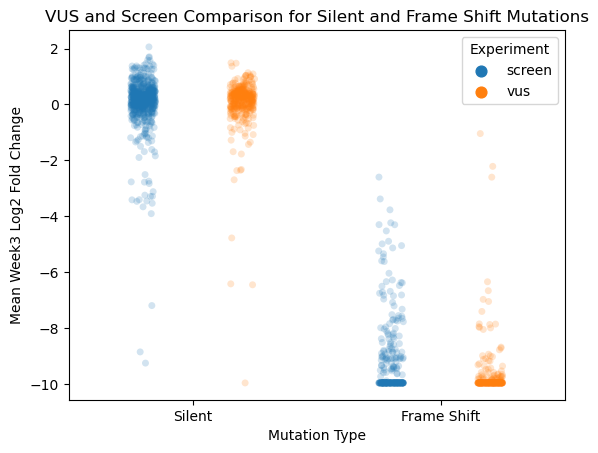

In [50]:
fig,ax = plt.subplots()
ax = sns.stripplot(data=boundaries_df, x="reclassed_mutation_type", y="mean_wk3_log2fc", hue="exp",dodge=True,alpha = 0.2)
ax.set_title("VUS and Screen Comparison for Silent and Frame Shift Mutations")
ax.set_xlabel('Mutation Type')
ax.set_ylabel('Mean Week3 Log2 Fold Change')
legend = plt.legend(title='Experiment')
fig.savefig(os.path.join(figure_output,'0d_vus-screen_Stripplot.png'),bbox_inches='tight')
fig.savefig(os.path.join(figure_output,'0d_vus-screen_Stripplot_Transparent.png'),bbox_inches='tight',transparent=True)
svg_path = os.path.join(figure_output,'0d_vus-screen_Stripplot.svg')
ai_path = os.path.join(figure_output,'0d_vus-screen_Stripplot.ai')
plt.rcParams['svg.fonttype'] = 'none'
# Save the heatmap as an SVG file
fig2.savefig(svg_path, format="svg")
# Convert the SVG file to AI format
cairosvg.svg2pdf(url=svg_path, write_to=ai_path)
plt.show()
plt.close()

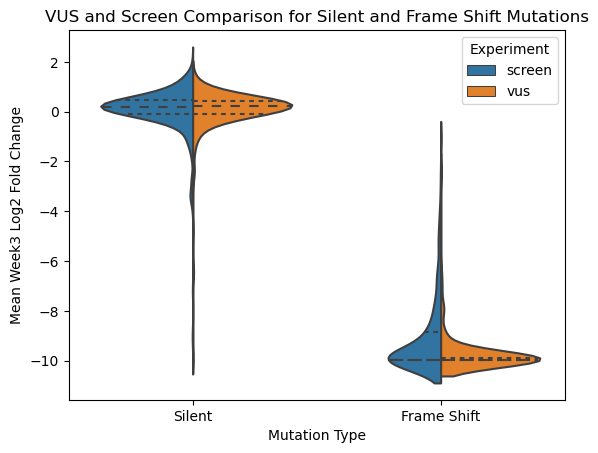

In [51]:
fig,ax = plt.subplots()
ax = sns.violinplot(data=boundaries_df, x="reclassed_mutation_type", y="mean_wk3_log2fc", hue="exp", split=True, inner="quart")
ax.set_title("VUS and Screen Comparison for Silent and Frame Shift Mutations")
ax.set_xlabel('Mutation Type')
ax.set_ylabel('Mean Week3 Log2 Fold Change')
legend = plt.legend(title='Experiment')
fig.savefig(os.path.join(figure_output,'0d_vus-screen_violinplot.png'),bbox_inches='tight')
fig.savefig(os.path.join(figure_output,'0d_vus-screen_violinplot_Transparent.png'),bbox_inches='tight',transparent=True)
svg_path = os.path.join(figure_output,'0d_vus-screen_violinplot.svg')
ai_path = os.path.join(figure_output,'0d_vus-screen_violinplot.ai')
plt.rcParams['svg.fonttype'] = 'none'
# Save the heatmap as an SVG file
fig2.savefig(svg_path, format="svg")
# Convert the SVG file to AI format
cairosvg.svg2pdf(url=svg_path, write_to=ai_path)
plt.show()
plt.close()

In [52]:
duplicate_muts = combined_3bioreps[combined_3bioreps.mutation_name.duplicated(keep=False)][['mutation_type','mutation_name','exp','mean_wk3_fc','mean_wk3_log2fc']].copy()
duplicate_muts = duplicate_muts.dropna()
targeted_muts = ['Silent','Alanine','Single Deletion','Substitution']
duplicate_muts = duplicate_muts[duplicate_muts.mutation_type.apply(lambda x: x in targeted_muts)]
duplicate_muts = duplicate_muts.sort_values(by=['mutation_name','exp'])
duplicate_muts

,mutation_type,mutation_name,exp,mean_wk3_fc,mean_wk3_log2fc
41,Single Deletion,A6del,screen,1.482403,0.550750
42,Single Deletion,A6del,vus,1.257310,-0.181984
1861,Silent,"AAA384AAG, TGT385TGC",screen,0.833715,-0.326053
1863,Silent,"AAA384AAG, TGT385TGC",vus,1.059892,0.070536
2181,Silent,"AAA407AAG, ACC408ACA",screen,1.166081,0.208675
...,...,...,...,...,...
58,Single Deletion,Y36del,vus,0.000023,-9.933163
2380,Single Deletion,Y501del,screen,0.025463,-5.244010
2381,Single Deletion,Y501del,vus,0.000351,-9.620144
3326,Single Deletion,Y600del,screen,1.047392,0.055129


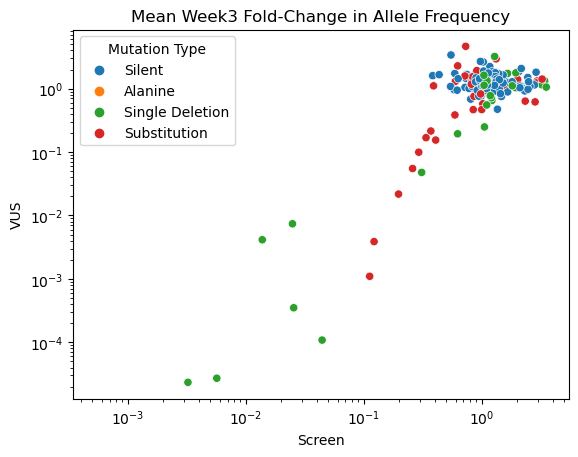

In [53]:
muts = unique(duplicate_muts.mutation_name.tolist())
dup_df = pd.DataFrame()
for mut in muts:
    tdf = duplicate_muts[duplicate_muts.mutation_name==mut].copy()
    if 'screen' in tdf.exp.tolist() and 'vus' in tdf.exp.tolist():
        dup_df.loc[mut,'Screen'] = tdf[tdf.exp=='screen']['mean_wk3_fc'].mean()
        dup_df.loc[mut,'VUS'] = tdf[tdf.exp=='vus']['mean_wk3_fc'].mean()
        dup_df.loc[mut,'type'] = tdf['mutation_type'].tolist()[0]

fig,ax = plt.subplots()
i = sns.scatterplot(data=dup_df,x='Screen',y='VUS',hue='type',hue_order=['Silent','Alanine','Single Deletion','Substitution'],ax=ax)
legend = plt.legend(title='Mutation Type')
plt.title('Mean Week3 Fold-Change in Allele Frequency')
plt.xscale('log')
plt.yscale('log')
fig.savefig(os.path.join(figure_output,'0e_ExpAgreement_FC.png'),bbox_inches='tight')
fig.savefig(os.path.join(figure_output,'0e_ExpAgreement_FC_Transparent.png'),bbox_inches='tight',transparent=True)
svg_path = os.path.join(figure_output,'0e_ExpAgreement_FC.svg')
ai_path = os.path.join(figure_output,'0e_ExpAgreement_FC.ai')
plt.rcParams['svg.fonttype'] = 'none'
# Save the heatmap as an SVG file
fig2.savefig(svg_path, format="svg")
# Convert the SVG file to AI format
cairosvg.svg2pdf(url=svg_path, write_to=ai_path)
plt.show()
plt.close()

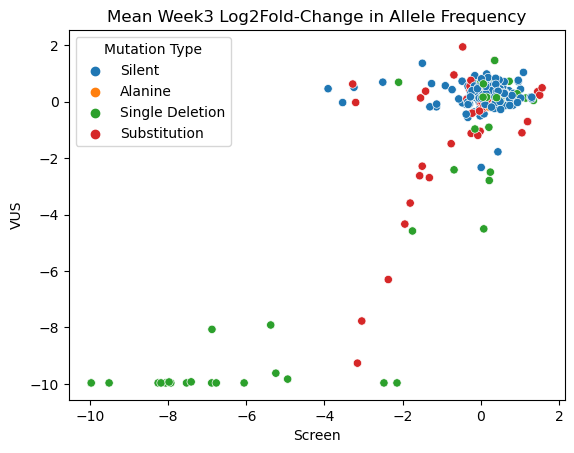

In [54]:
dup_df = pd.DataFrame()
for mut in muts:
    tdf = duplicate_muts[duplicate_muts.mutation_name==mut].copy()
    if 'screen' in tdf.exp.tolist() and 'vus' in tdf.exp.tolist():
        dup_df.loc[mut,'Screen'] = tdf[tdf.exp=='screen']['mean_wk3_log2fc'].mean()
        dup_df.loc[mut,'VUS'] = tdf[tdf.exp=='vus']['mean_wk3_log2fc'].mean()
        dup_df.loc[mut,'type'] = tdf['mutation_type'].tolist()[0]

fig,ax = plt.subplots()
i = sns.scatterplot(data=dup_df,x='Screen',y='VUS',hue='type',hue_order=['Silent','Alanine','Single Deletion','Substitution'],ax=ax)
legend = plt.legend(title='Mutation Type')
plt.title('Mean Week3 Log2Fold-Change in Allele Frequency')
fig.savefig(os.path.join(figure_output,'0e_ExpAgreement_Log2FC.png'),bbox_inches='tight')
fig.savefig(os.path.join(figure_output,'0e_ExpAgreement_Log2FC_Transparent.png'),bbox_inches='tight',transparent=True)
svg_path = os.path.join(figure_output,'0e_ExpAgreement_Log2FC.svg')
ai_path = os.path.join(figure_output,'0e_ExpAgreement_Log2FC.ai')
plt.rcParams['svg.fonttype'] = 'none'
# Save the heatmap as an SVG file
fig2.savefig(svg_path, format="svg")
# Convert the SVG file to AI format
cairosvg.svg2pdf(url=svg_path, write_to=ai_path)
plt.show()
plt.close()